# Code Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


from naive_bayes_classifier import NaiveBayes

# Reading the Data

In [ ]:
inflammation_data = pd.read_csv('./inflammation_diagnosis.csv', delimiter=';')

# Inspecting the Data

In [ ]:
inflammation_data.info()

# Plot the data

plot with seaborn, use different colors and sort the values by colors

In [ ]:
import seaborn as sns

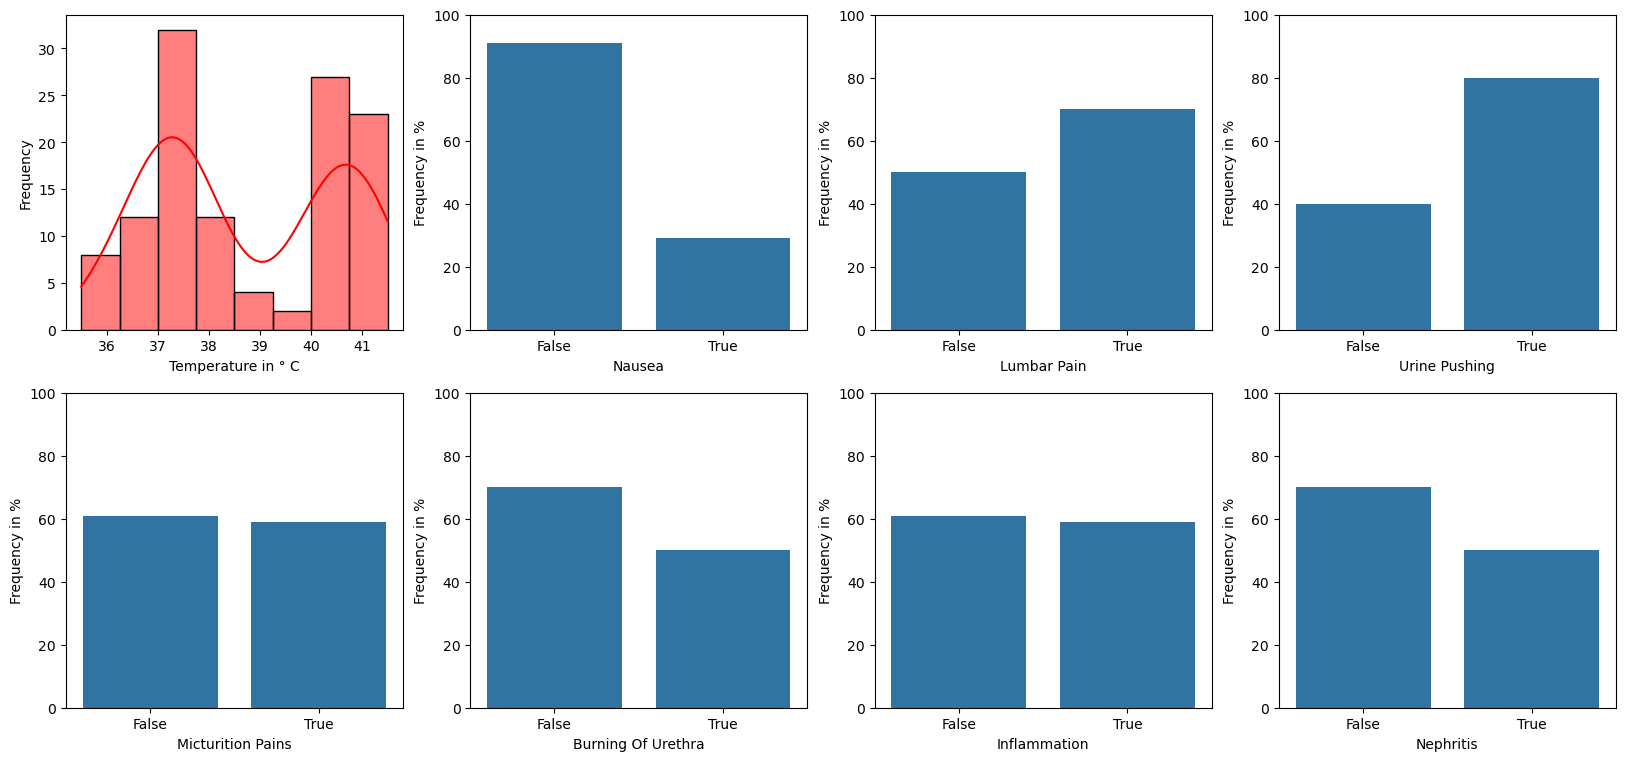

In [84]:
rows = 2
columns = 4
fig,ax = plt.subplots(nrows=rows, ncols=columns, figsize=(20,9))
[""]
index = 0 

for row in range(rows):
    for column in range(columns):
        nice_col_name = inflammation_data.columns.to_list()[index]
        nice_col_name = " ".join(word[0].upper() + word[1:] for word in nice_col_name.split("_"))
        
        
        if inflammation_data.columns[index] == 'temperature':
            s = sns.histplot(inflammation_data, ax=ax[row,column], x=inflammation_data.columns[column], kde=True, color='r')
            s.set(xlabel = 'Temperature in ° C', ylabel = "Frequency")
            
        else:
            b = sns.countplot(inflammation_data, x=inflammation_data.columns[index], ax=ax[row,column])
            b.set(xlabel = nice_col_name, ylabel = 'Frequency in %')
            b.set_ylim(0,100)
            
        index += 1

# Creating Labels
## Transforming Nominal Data to Booleans

In [ ]:
inflammation_data = inflammation_data.replace(to_replace='no', value=False)
inflammation_data = inflammation_data.replace(to_replace='yes', value=True)

inflammation_data

Checking if the columns are indeed of type boolean

In [ ]:
inflammation_data.info()

## Adding Disease Labels 
Add the disease values to a new label-column and check if the values make sense

In [ ]:
inflammation_data['disease'] = [False if (inflammation_data['inflammation'][i] == False) & (inflammation_data['nephritis'][i] == False) else True for i in range(0,len(inflammation_data))]

# Splitting the Data
Count the values of 'disease' to see how the data is distributed

In [38]:
inflammation_data['disease'].value_counts(True)

disease
True     0.75
False    0.25
Name: proportion, dtype: float64

## Calculating Split Indices
The data split must account for the obvious imbalance in the data. Therefore, calculate the indices of the splits.

In [ ]:
train = pd.concat([inflammation_data[inflammation_data['disease'] == True].sample(frac =0.8), inflammation_data[inflammation_data['disease'] == False].sample(frac = 0.8)])
test = inflammation_data.drop(train.index)

In [ ]:
set(list(test.index)).isdisjoint(list(train.index))

In [ ]:
l = sorted(train.index)
l

In [ ]:
test.index

## Ensuring that the two dataframes do not share a column
The following merge shows duplicate rows across the two dataframes. If empty, there are no duplicates.

In [34]:
result = train.merge(right=test, how='inner', indicator=False)
result

,temperature,nausea,lumbar_pain,urine_pushing,micturition_pains,burning_of_urethra,inflammation,nephritis,disease
0,37.6,False,False,True,True,False,True,False,True
1,37.0,False,False,True,True,True,True,False,True
2,37.0,False,False,True,True,True,True,False,True
3,37.0,False,False,True,True,True,True,False,True
4,36.8,False,False,True,True,True,True,False,True
5,40.4,True,True,True,True,False,True,True,True
6,37.5,False,False,True,False,False,True,False,True
7,40.0,False,False,False,False,False,False,False,False
8,37.5,False,True,False,False,False,False,False,False
9,36.6,False,True,False,False,False,False,False,False


In [35]:
inflammation_data.groupby(["disease", inflammation_data["disease"]]).size()

disease  disease
False    False      30
True     True       90
dtype: int64

# TESTING

{False: {35.5: 0.08093794685167072, 35.9: 0.10531400471221081, 36.0: 0.111722585573334, 36.2: 0.12472006120087231, 36.3: 0.13124319744482887, 36.6: 0.15047679680980475, 36.7: 0.15664776670368014, 36.8: 0.16263253182005633, 36.9: 0.16839111945305185, 37.0: 0.17388394745530067, 37.1: 0.17907227175823015, 37.2: 0.1839186376308664, 37.3: 0.18838732739899353, 37.4: 0.19244479718721544, 37.5: 0.19606009524469586, 37.6: 0.19920525457561405, 37.7: 0.201855652917869, 37.8: 0.20399033359414984, 37.9: 0.2055922813895951, 38.0: 0.20664864837712235, 38.1: 0.20715092549846686, 38.3: 0.20648149345312364, 38.5: 0.2036055303359299, 38.7: 0.19861506655317407, 38.9: 0.1916677270921734, 39.0: 0.18752544838212548, 39.4: 0.1672594052803271, 39.7: 0.14922377739651047, 40.0: 0.1299398680347538, 40.1: 0.12341491355049486, 40.2: 0.11690185724974751, 40.3: 0.11043423427921553, 40.4: 0.10404341132033214, 40.5: 0.09775837813158042, 40.6: 0.09160558194171306, 40.7: 0.08560880481175745, 40.8: 0.07978908329224611, 40

# positiv posterior soll grösser sein als negative posterior

evidence noch berechnen mit negative and ppositive posterior 

In [41]:
Y_test= test.iloc[:,-1].values
X_test = test.iloc[:,:-1].values

In [43]:
t = NaiveBayes()
p,f = t.fit(train, "disease")
print(p)
print("''''''''''''''")
print(f)

{False: {37.7: 0.186564237585967, 37.9: 0.19101932775010994, 37.6: 0.1837188356559781, 36.3: 0.12115282554200442, 38.7: 0.19086786296666258, 38.5: 0.19365109645992942, 40.4: 0.11491617075323468, 36.0: 0.10394455094111525, 40.7: 0.0978341414220967, 40.0: 0.13775256696990523, 41.1: 0.076354347741744, 40.1: 0.13212053325196293, 37.0: 0.15936825612676894, 40.5: 0.10917362914036832, 39.4: 0.1683342205580518, 40.9: 0.08684185921762974, 35.9: 0.09830088913394215, 41.3: 0.06649736160588544, 36.8: 0.14912478612341826, 38.9: 0.18634238325996427, 37.5: 0.18048680913815654, 37.2: 0.16870182900059782, 41.2: 0.07134045007620103, 36.9: 0.1543450049852904, 40.2: 0.12641756801499962, 37.3: 0.17295316758192647, 41.5: 0.05736421317392829, 41.4: 0.06183572821375608, 40.6: 0.1034715237540264, 36.6: 0.1382177538919801, 39.0: 0.18346397844596626, 40.3: 0.12067325866634684, 36.2: 0.11539574038539757, 37.8: 0.18900339573251315, 37.1: 0.1641638609804379, 38.1: 0.19372791794316113, 38.0: 0.19259788500750724, 41.